In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.odr import *
import scipy.stats

In [2]:
# Constants
g = 9.81 # m/s^2 gravitational accleleration
delta_g = 0.1
r = 0.025 # m radius of disk in which the string was wound to
delta_r = 0.0005
R = 0.122 # m radius of the disk
delta_R = 0.0005
M = 1.134 # kg mass of the disk
delta_M = 0.005
l = 0.275 # m axis of rotation to mass dropped
delta_l = 0.0005

In [3]:
# Linear fit function
def linear(p, x):
    a, b = p
    return a*x+b

# Create a model
model = Model(linear)

# Moment of Rotational Inertia
Calculating the moment of inertia using 2 techniques
- Direct measurement of rotational inertia for the gyroscopic disk
- Measurement of precession frequency

###  Theoretical value

In [4]:
I_theory = 0.5*M*R**2
delta_I_theory = I_theory*((2*delta_R/R)**2+(delta_M/M)**2)**0.5
print("I = {:.2f} +/- {:.2f}".format(
  I_theory*1000, delta_I_theory*1000)+" x10^-3 kgm^2")

I = 8.44 +/- 0.08 x10^-3 kgm^2


###  Moment of Inertia of a Disk

In [5]:
# Experimental data
m = 0.11 # kg hanging mass
delta_m = 0.001
h = np.array([0.8, 0.7, 0.6, 0.5, 0.4]) # m heights the mass was dropped from
h_err = 0.01 # error from parallax
t_f = np.array([4.53, 4.38, 3.98, 3.53, 3.33]) # s time to reach the ground
t_f_err = np.array([0.075, 0.095, 0.065, 0.05, 0.095]) # due to human reaction time

Beta: [26.19656829  0.04496788]
Beta Std Error: [2.38425503 1.46290497]
Beta Covariance: [[ 0.9621442  -0.57519006]
 [-0.57519006  0.36221546]]
Residual Variance: 5.908336861795203
Inverse Condition #: 0.007162000537710829
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (26.2 +/- 2.4) * x + (0.0 +/- 1.5)


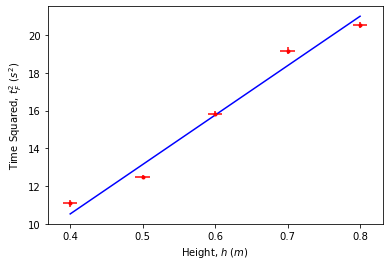

In [6]:
# Plot the curve

# Convert data and error into a form recognised by ODR
free_fall = RealData(h, t_f**2, sx=h_err, sy=2*t_f_err)

# Set up ODR
odr_f = ODR(free_fall, model, beta0=[25, 0.5]) # initial guess is y=25x+0.5

# run the regression
out_f = odr_f.run()
out_f.pprint()

print("Line of best fit:"+"y = ({:.1f} +/- {:.1f}) * x + ({:.1f} +/- {:.1f})".format(
  out_f.beta[0], out_f.sd_beta[0],
  out_f.beta[1], out_f.sd_beta[1]))

plt.figure()
plt.errorbar(h, t_f**2, xerr=h_err, yerr=2*t_f_err, fmt='.', color='red')
plt.plot(h, linear(out_f.beta, h), color='blue')

plt.xlabel("Height, $h$ ($m$)")
plt.ylabel("Time Squared, $t_F^2$ ($s^2$)")

plt.show()

In [7]:
# Calculating the moment of inertia
I_f = (out_f.beta[0]*m*g*r**2-2*m*r**2)/2
delta_I_f = I_f*((out_f.sd_beta[0]/out_f.beta[0])**2
                 +(2*delta_r/r)**2+(delta_m/m)**2+(delta_g/g)**2)**0.5

print("I = {:.2f} +/- {:.2f}".format(
  I_f*1000, delta_I_f*1000)+" x10^-3 kgm^2")

I = 8.77 +/- 0.88 x10^-3 kgm^2


In [8]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(h, t_f**2)

r_value**2

0.975957269267263

within uncertainty

### Precession Frequency (changing both mass and spin) - Not used in report


In [9]:
# Experimental data
mass = np.array([0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09])
delta_mass = delta_m
tau = mass*g*l
delta_tau = tau*((delta_mass/mass)**2+(delta_g/g)**2+(delta_l/l)**2)**0.5
w_s1 = 40*np.pi/np.array([2.77, 2.75, 3.81, 3.1, 2.97, 2.69, 2.83, 2.77, 2.89, 2.56, 4.06, 2.89])
w_s2 = 40*np.pi/np.array([5.06, 4.15, 6.18, 5.17, 4.75, 6.47, 4.32, 4.19, 4.38, 4.52, 6.67, 4.6])
w_s = (w_s1+w_s2)/2 # mean of 2 w_s
delta_w_s = abs(w_s1-w_s2)/2 # range/2
t_p = np.array([13.65, 15.23, 11.08, 10.93, 11.33, 11.45, 10.91, 9.96, 10.88, 9.93, 7.23, 9.45])
delta_t_p = 0.1
delta_y=tau/w_s*((delta_tau/tau)**2+(delta_w_s/w_s)**2)**0.5
w_p = 2*np.pi/t_p
delta_w_p = 2*np.pi*delta_t_p/(t_p)**2

Beta: [ 1.03089602e-02 -9.80246168e-05]
Beta Std Error: [0.00096812 0.00054276]
Beta Covariance: [[ 1.63786455e-05 -9.04571456e-06]
 [-9.04571456e-06  5.14802829e-06]]
Residual Variance: 0.05722429108178277
Inverse Condition #: 0.0003848863217622281
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.010309 +/- 0.000968) * x + (-0.000098 +/- 0.000543)


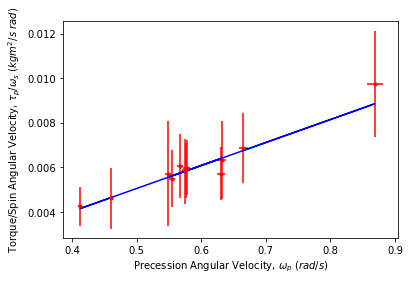

I = 10.31 +/- 0.97 x10^-3 kgm^2


In [10]:
# Plot the curve

# Convert data and error into a form recognised by ODR
precession = RealData(w_p, tau/w_s, sx=delta_w_p, sy=delta_y)

# Set up ODR
odr_p = ODR(precession, model, beta0=[0.0008, 0.2])

# run the regression
out_p = odr_p.run()
out_p.pprint()

print("Line of best fit:"+"y = ({:.6f} +/- {:.6f}) * x + ({:.6f} +/- {:.6f})".format(
  out_p.beta[0], out_p.sd_beta[0],
  out_p.beta[1], out_p.sd_beta[1]))

plt.figure()
plt.errorbar(w_p, tau/w_s, xerr=delta_w_p, yerr=delta_y, fmt='.', color='red')
plt.plot(w_p, linear(out_p.beta, w_p), color='blue')

plt.xlabel("Precession Angular Velocity, $\omega_p$ ($rad/s$)")
plt.ylabel("Torque/Spin Angular Velocity, $τ_p/\omega_s$ ($kgm^2/s$ $rad$)")

plt.show()

print("I = {:.2f} +/- {:.2f}".format(
  out_p.beta[0]*1000, out_p.sd_beta[0]*1000)+" x10^-3 kgm^2")

not within uncertainty
### Precession- Torque Dependent Measurements

In [11]:
# Experimental data
mass2 = np.array([0.06, 0.07, 0.08, 0.09, 0.1])
delta_mass2 = delta_m
tau2 = mass2*g*l
delta_tau2 = tau2*((delta_mass2/mass2)**2+(delta_g/g)**2+(delta_l/l)**2)**0.5
t_s_2 = 0.194273333 
delta_t_s_2 = 0.02825
w_s_2 = 4*np.pi/t_s_2
delta_w_s_2 = 2*np.pi*delta_t_s_2/(t_s_2)**2
t_p2 = np.array([12.98666667, 11.23666667, 10.58333333, 9.536666667, 9.233333333])
delta_t_p2 = np.array([0.785, 0.26, 0.475, 0.35, 0.44])
w_p2 = 2*np.pi/t_p2
delta_w_p2 = 2*np.pi*delta_t_p2/(t_p2)**2

Beta: [ 0.55880424 -0.119935  ]
Beta Std Error: [0.06297994 0.03687903]
Beta Covariance: [[ 0.0102079  -0.0059504 ]
 [-0.0059504   0.00350019]]
Residual Variance: 0.3885687449701951
Inverse Condition #: 0.005282775081120495
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.558804 +/- 0.062980) * x + (-0.119935 +/- 0.036879)


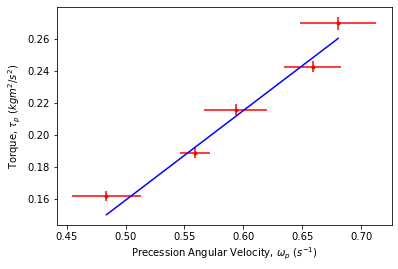

In [12]:
# Plot the curve

# Convert data and error into a form recognised by ODR
precession2 = RealData(w_p2, tau2, sx=delta_w_p2, sy=delta_tau2)

# Set up ODR
odr_p2 = ODR(precession2, model, beta0=[0.03, 0.3])

# run the regression
out_p2 = odr_p2.run()
out_p2.pprint()

print("Line of best fit:"+"y = ({:.6f} +/- {:.6f}) * x + ({:.6f} +/- {:.6f})".format(
  out_p2.beta[0], out_p2.sd_beta[0],
  out_p2.beta[1], out_p2.sd_beta[1]))

plt.figure()
plt.errorbar(w_p2, tau2, xerr=delta_w_p2, yerr=delta_tau2, fmt='.', color='red')
plt.plot(w_p2, linear(out_p2.beta, w_p2), color='blue')

plt.xlabel("Precession Angular Velocity, $\omega_p$ ($s^{-1}$)")
plt.ylabel("Torque, $τ_p$ ($kgm^2/s^2$)")

plt.show()

In [13]:
I_p2 = out_p2.beta[0]/w_s_2
delta_I_p2 = I_p2*((out_p2.sd_beta[0]/out_p2.beta[0])**2
                 +(delta_w_s_2/w_s_2)**2)**0.5

print("I = {:.2f} +/- {:.2f}".format(
  I_p2*1000, delta_I_p2*1000)+" x10^-3 kgm^2")

I = 8.64 +/- 1.16 x10^-3 kgm^2


In [14]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(w_p2, tau2)

r_value**2

0.9710500880091066

### Precession Frequency and Spin Frequency

In [15]:
mass3 = 0.05 #kg
delta_mass3 = delta_m
tau3 = mass3*g*l
delta_tau3 = tau3*((delta_mass3/mass3)**2+(delta_g/g)**2+(delta_l/l)**2)**0.5


data = pd.read_csv('wp-vs-ws.txt', sep='\t', header = 0) # data for varying magnetic field
data.columns = ['Ts1', 'Ts2', 'Tsav', 'dTsav', 'Tp', 'dTp'] #column headings
T_s = data.Tsav
delta_T_s = data.dTsav
T_p = data.Tp
delta_T_p = data.dTp

w_s_3 = 2*np.pi/T_s
delta_w_s_3 =w_s_3*delta_T_s/T_s
w_p3 = 4*np.pi/T_p
delta_w_p3 =2*np.pi*delta_T_p/(T_p**2)
delta_x =delta_w_s_3/w_s_3**2

Beta: [11.64326995 -0.01781606]
Beta Std Error: [3.37306459 0.07126566]
Beta Covariance: [[ 1.62508631e+02 -3.41164321e+00]
 [-3.41164321e+00  7.25416928e-02]]
Residual Variance: 0.07001206419420912
Inverse Condition #: 0.002334528568896877
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (11.643270 +/- 3.373065) * x + (-0.017816 +/- 0.071266)


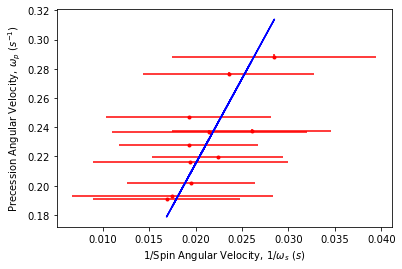

In [16]:
# Plot the curve

# Convert data and error into a form recognised by ODR
precession3 = RealData(1/w_s_3, w_p3, sx=delta_x, sy=delta_w_p3)

# Set up ODR
odr_p3 = ODR(precession3, model, beta0=[0.1, 0.3])

# run the regression
out_p3 = odr_p3.run()
out_p3.pprint()

print("Line of best fit:"+"y = ({:.6f} +/- {:.6f}) * x + ({:.6f} +/- {:.6f})".format(
  out_p3.beta[0], out_p3.sd_beta[0],
  out_p3.beta[1], out_p3.sd_beta[1]))

plt.figure()
plt.errorbar(1/w_s_3, w_p3, xerr=delta_x, yerr=delta_w_p3, fmt='.', color='red')
plt.plot(1/w_s_3, linear(out_p3.beta, 1/w_s_3), color='blue')

plt.xlabel("1/Spin Angular Velocity, $1/\omega_s$ ($s$)")
plt.ylabel("Precession Angular Velocity, $\omega_p$ ($s^{-1}$)")

plt.show()

In [17]:
I_p3 = tau3/out_p3.beta[0]
delta_I_p3 = I_p3*((out_p3.sd_beta[0]/out_p3.beta[0])**2
                 +(delta_tau3/tau3)**2)**0.5

print("I = {:.2f} +/- {:.2f}".format(
  I_p3*1000, delta_I_p3*1000)+" x10^-3 kgm^2")

I = 11.59 +/- 3.37 x10^-3 kgm^2


In [18]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(1/w_s_3, w_p3)\

r_value**2

0.6445432734022871

# Nutation

In [19]:
# Experimental Data
ws1 = 2*np.pi/np.array([8.33/53, 4.86/24, 5.86/36, 7.02/41, 6.44/37, 8/42, 9.57/57, 7.49/48])
ws2 = 40*np.pi/np.array([6.11, 5.84, 7.61, 6.23, 5.25, 6.37, 6.11, 4.54])
ws = (ws1+ws2)/2
delta_ws = abs(ws1-ws2)
tn = np.array([5.3, 5.69, 5.06, 5.33, 5.66, 5.93, 4.76, 4.16])/5
wn = 2*np.pi/tn
delta_wn = wn*0.02/tn**2

Beta: [ 0.33374522 -3.62349583]
Beta Std Error: [0.0862436  2.49065579]
Beta Covariance: [[  0.53312941 -15.35005634]
 [-15.35005634 444.63770367]]
Residual Variance: 0.013951507528542476
Inverse Condition #: 0.00010726057234110244
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (0.33 +/- 0.09) * x + (-3.62 +/- 2.49)


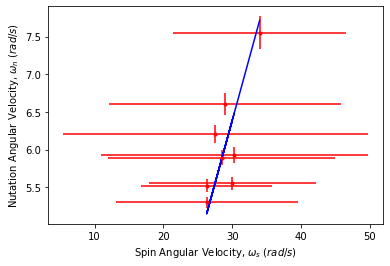

In [20]:
# Plot the curve

# Convert data and error into a form recognised by ODR
nutation = RealData(ws, wn, sx=delta_ws, sy=delta_wn)

# Set up ODR
odr_n = ODR(nutation, model, beta0=[2.5, 0.1])

# run the regression
out_n = odr_n.run()
out_n.pprint()

print("Line of best fit:"+"y = ({:.2f} +/- {:.2f}) * x + ({:.2f} +/- {:.2f})".format(
  out_n.beta[0], out_n.sd_beta[0],
  out_n.beta[1], out_n.sd_beta[1]))

plt.figure()
plt.errorbar(ws, wn, xerr=delta_ws, yerr=delta_wn, fmt='.', color='red')
plt.plot(ws, linear(out_n.beta, ws), color='blue')

plt.xlabel("Spin Angular Velocity, $\omega_s$ ($rad/s$)")
plt.ylabel("Nutation Angular Velocity, $\omega_n$ ($rad/s$)")

plt.show()

In [21]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ws, wn)\

r_value**2

0.6203936508379397

#### Improvements:
- more masses for the precesion part and then plot the torque against the ratio of spin and precession angular velocities
- measure the final spin time immediately after the precession or nutation
- drop different masses whilst keeping the velocity relatively constant for nutation to get relationship between nutation and strength of knock
- Experiment with having 2 disks

### Mass and Nutation

In [22]:
# Experimental Data
wss = 34.37054
delta_wss = 14.19024739
masss = np.array([0.04, 0.08, 0.1, 0.143])
delta_masss = delta_m
tnn = np.array([4.34, 4.91, 5.16, 6.16])/5
wnn = 2*np.pi/tnn
delta_wnn = wnn*0.02/tnn**2

Beta: [-21.01577518   8.11685095]
Beta Std Error: [0.82675647 0.10026755]
Beta Covariance: [[ 2.54611121 -0.29704418]
 [-0.29704418  0.03744924]]
Residual Variance: 0.26845891642124065
Inverse Condition #: 0.07273147703988007
Reason(s) for Halting:
  Sum of squares convergence
Line of best fit:y = (-21.02 +/- 0.83) * x + (8.12 +/- 0.10)


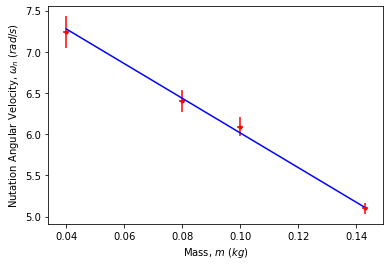

In [23]:
# Plot the curve

# Convert data and error into a form recognised by ODR
nutation2 = RealData(masss, wnn, sx=delta_masss, sy=delta_wnn)

# Set up ODR
odr_n2 = ODR(nutation2, model, beta0=[2.5, 0.1])

# run the regression
out_n2 = odr_n2.run()
out_n2.pprint()

print("Line of best fit:"+"y = ({:.2f} +/- {:.2f}) * x + ({:.2f} +/- {:.2f})".format(
  out_n2.beta[0], out_n2.sd_beta[0],
  out_n2.beta[1], out_n2.sd_beta[1]))

plt.figure()
plt.errorbar(masss, wnn, xerr=delta_masss, yerr=delta_wnn, fmt='.', color='red')
plt.plot(masss, linear(out_n2.beta, masss), color='blue')

plt.xlabel("Mass, $m$ ($kg$)")
plt.ylabel("Nutation Angular Velocity, $\omega_n$ ($rad/s$)")

plt.show()

In [24]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(masss, wnn)\

r_value**2

0.9969226038688708